## Exercise 1
<!-- @q -->
In this exercise, you will use RandomSearch, GridSearch, and HyperOpt to maximize your performance on ARI.

First, we'll set up some data. Note that all we're doing here is plotting some sine curves in 2D.

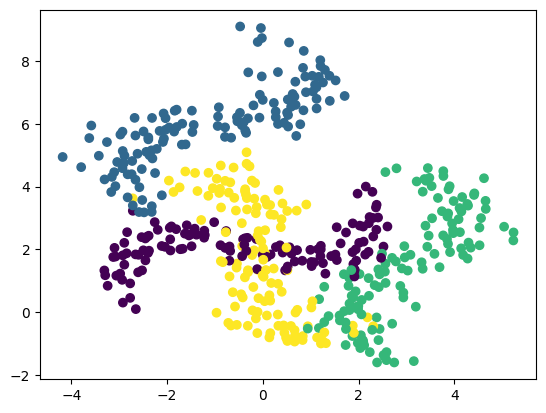

In [1]:
#@SHOW

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def make_squiggle_clusters(
    n_clusters=3, 
    n_points=500, 
    scaling = 1,
    noise=0.05, 
    rotations=None, 
    seed=42
):
    """
    Generate squiggly clusters by sampling from sine curves, then rotating/translating them.
    
    Parameters
    ----------
    n_clusters : int
        Number of squiggle clusters.
    n_points : int
        Total number of points (split evenly across clusters).
    noise : float
        Standard deviation of Gaussian noise around each squiggle.
    scaling : float
        Applied to scale the size of the sine curves
    rotations : list of floats (optional)
        List of rotation angles in radians for each cluster.
        If None, rotations are drawn randomly.
    seed : int
        Random seed for reproducibility.
        
    Returns
    -------
    X : np.ndarray of shape (n_points, 2)
        Feature coordinates.
    y : np.ndarray of shape (n_points,)
        Ground truth cluster labels.
    """
    rng = np.random.default_rng(seed)
    points_per_cluster = n_points // n_clusters
    t = np.linspace(0, 2*np.pi, points_per_cluster)

    X_list, y_list = [], []

    for i in range(n_clusters):
        # Base squiggle = sine wave
        x = t
        y = scaling * np.sin(t) + rng.normal(0, noise, size=points_per_cluster)

        coords = np.vstack([x, y]).T

        # Apply rotation
        if rotations is None:
            theta = rng.uniform(0, np.pi)
        else:
            theta = rotations[i % len(rotations)]

        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]])
        coords = coords @ R.T

        # Translate cluster to avoid total overlap
        offset = rng.uniform(-4, 4, size=2)
        coords += offset

        X_list.append(coords)
        y_list.append(np.full(points_per_cluster, i))

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    return shuffle(X, y, random_state=seed)


X,y = make_squiggle_clusters(n_clusters=4,noise=.5, scaling=1) 
plt.scatter(X[:,0],X[:,1],c=y)   

The following function is a corrected adjusted rand score that effectively penalizes noise points

In [2]:
#@SHOW
from sklearn.metrics import adjusted_rand_score
import numpy as np

def ari_with_singleton_noise(y_true, y_pred, noise_label=-1):
    y_pred = np.asarray(y_pred).copy()
    # assign a unique cluster id to each noise point
    mask = (y_pred == noise_label)
    unique_ids = np.arange(y_pred.max() + 1, y_pred.max() + 1 + mask.sum())
    y_pred[mask] = unique_ids
    return adjusted_rand_score(y_true, y_pred)

And here's a visualization function that will allow you to compare ground truth to your best clustering.

In [3]:
#@SHOW
def comparison_plot(X,y_pred,y_true,title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- True labels ---
    unique_true = np.unique(y_true)
    for label in unique_true:
        mask = y_true == label
        color = "lightgray" if label == -1 else None
        axes[0].scatter(X[mask, 0], X[mask, 1], s=20, label=f"Cluster {label}", c=color)
    axes[0].set_title("Ground Truth")
    axes[0].legend(loc="best", fontsize=8)

    # --- Predicted labels ---
    # @FILL begin
    unique_pred = np.unique(y_pred)
    for label in unique_pred:
        mask = y_pred == label
        color = "lightgray" if label == -1 else None
        axes[1].scatter(X[mask, 0], X[mask, 1], s=20, label=f"Cluster {label}", c=color)
    axes[1].set_title(f"{title}")
    # @FILL end

    plt.tight_layout()
    plt.show()

### Optimize with GridSearchCV


HDBScan does not have a `predict` method, which is used by factory constructed scorers in sklearn.  To accomodate this, we'll define our own scorer.  Also note that since sklearn optimizers are set up for classification problems, rather than clustering, we have to use a manually constructed fold structure for the `cv` parameter.  An example of this is in the lecture notes.

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.cluster import HDBSCAN

# Custom scorer using singletonized ARI - this replaces the default scoring mechanism with a call to `fit_predict` 
# rather than predict
def scorer(estimator, X, y_true):
    labels = estimator.fit_predict(X)
    return ari_with_singleton_noise(y_true, labels)


# Single fold strategy - this is plugged into the `cv` parameter of the optimizer
n = X.shape[0]
one_fold = [(np.arange(n), np.arange(n))]

# TODO: Replace with your code (fill)

param_grid = { # 4x3x3 = 36 trials
    'min_cluster_size': [5, 10, 15, 20],
    'min_samples': [1, 5, 10],
    'cluster_selection_epsilon': [0.0, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=HDBSCAN(),
    param_grid=param_grid,
    scoring=scorer,
    cv=one_fold
)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best ARI:", grid.best_score_)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserW

Best params: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 15, 'min_samples': 1}
Best ARI: 0.28785003951817906


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)


### Visualize your results

Use the `comparison_plot` function to compare your best results to ground truth.

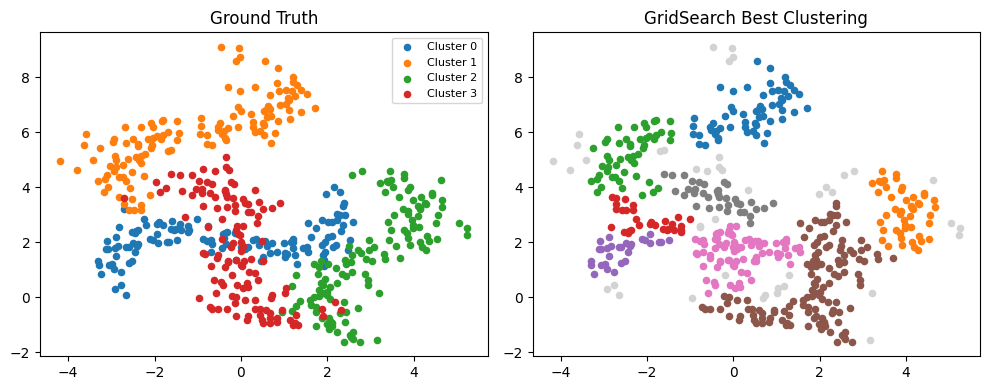

In [6]:
# Get the best model from the grid search
best_model = grid.best_estimator_

# Generate predicted labels
best_labels = best_model.fit_predict(X)

# Visualize the clustering result vs the true labels
comparison_plot(X, best_labels, y, "GridSearch Best Clustering")

### Optimize with RandomSearchCV


Now try with `RandomSearchCV`. Because we're operating with sklearn, the same rules apply with respect folds and scorers (you can reuse these objects from above). Additionally, a RandomSearch optimizer allows you search a larger possible space than GridSearchCV but control the number of evaluations.  To make this a fair competition, make sure you use the same total number of trials as you used with the GridSearch.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.cluster import HDBSCAN

param_dist = {
    'min_cluster_size': randint(5, 30),           # uniform integers between 5–30
    'min_samples': randint(1, 15),                # uniform integers between 1–15
    'cluster_selection_epsilon': uniform(0.0, 0.3) # continuous uniform [0, 0.3)
}

random_search = RandomizedSearchCV(
    estimator=HDBSCAN(metric='euclidean'),
    param_distributions=param_dist,
    n_iter=36,                # same number of total trials as GridSearch
    scoring=scorer,           # reuse the custom ARI scorer
    cv=one_fold,              # reuse the single-fold CV
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# --- fit the search ---
random_search.fit(X, y)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END cluster_selection_epsilon=0.11236203565420874, min_cluster_size=19, min_samples=11; total time=   0.0s
[CV] END cluster_selection_epsilon=0.23390730008183078, min_cluster_size=25, min_samples=7; total time=   0.0s
[CV] END cluster_selection_epsilon=0.13374982585607734, min_cluster_size=27, min_samples=11; total time=   0.0s
[CV] END cluster_selection_epsilon=0.13777466758976015, min_cluster_size=25, min_samples=4; total time=   0.0s
[CV] END cluster_selection_epsilon=0.04286004537658223, min_cluster_size=7, min_samples=6; total time=   0.0s
[CV] END cluster_selection_epsilon=0.016923473708130077, min_cluster_size=28, min_samples=12; total time=   0.0s
[CV] END cluster_selection_epsilon=0.281565812704725, min_cluster_size=6, min_samples=12; total time=   0.0s
[CV] END cluster_selection_epsilon=0.055021352956030146, min_cluster_size=16, min_samples=10; total time=   0.0s
[CV] END cluster_selection_epsilon=0.15742692948

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)


[CV] END cluster_selection_epsilon=0.20526990795364705, min_cluster_size=19, min_samples=12; total time=   0.0s
[CV] END cluster_selection_epsilon=0.036611470453433645, min_cluster_size=12, min_samples=3; total time=   0.0s
[CV] END cluster_selection_epsilon=0.19875668530619459, min_cluster_size=6, min_samples=14; total time=   0.0s
[CV] END cluster_selection_epsilon=0.2727961206236346, min_cluster_size=8, min_samples=2; total time=   0.0s
[CV] END cluster_selection_epsilon=0.15602040635334324, min_cluster_size=14, min_samples=4; total time=   0.0s
[CV] END cluster_selection_epsilon=0.05545633665765811, min_cluster_size=22, min_samples=10; total time=   0.0s
[CV] END cluster_selection_epsilon=0.1349262400109297, min_cluster_size=14, min_samples=14; total time=   0.0s
[CV] END cluster_selection_epsilon=0.2779976597381382, min_cluster_size=20, min_samples=8; total time=   0.0s
[CV] END cluster_selection_epsilon=0.0975990992289793, min_cluster_size=20, min_samples=13; total time=   0.0s
[

,estimator,HDBSCAN()
,param_distributions,"{'cluster_selection_epsilon': <scipy.stats....x7db53c590ce0>, 'min_cluster_size': <scipy.stats....x7db537275eb0>, 'min_samples': <scipy.stats....x7db5372772f0>}"
,n_iter,36
,scoring,<function sco...x7db536ed05e0>
,n_jobs,-1
,refit,True
,cv,"[(array([ 0, ...97, 498, 499]), ...)]"
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### Visualize your results

Once, again, visualize your best results.

Best params (RandomSearchCV): {'cluster_selection_epsilon': np.float64(0.11562495076197482), 'min_cluster_size': 25, 'min_samples': 2}
Best ARI: 0.30508924767267187


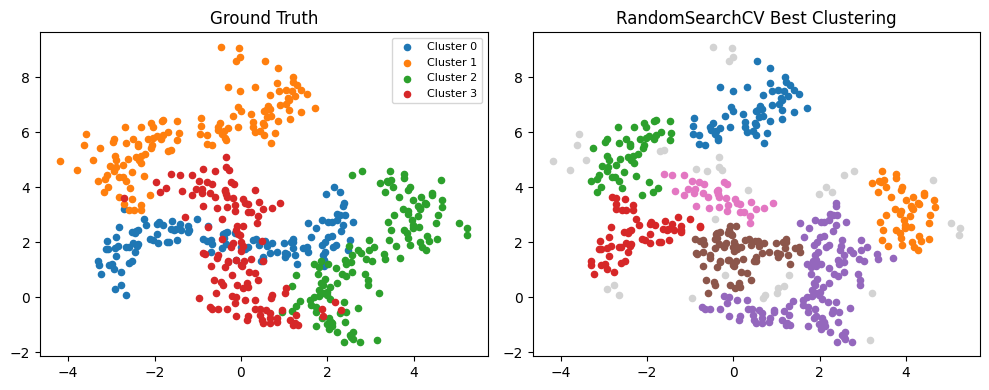

In [10]:
# Your code here
print("Best params (RandomSearchCV):", random_search.best_params_)
print("Best ARI:", random_search.best_score_)
best_random_model = random_search.best_estimator_
best_random_labels = best_random_model.fit_predict(X)

comparison_plot(X, best_random_labels, y, "RandomSearchCV Best Clustering")

### Optimize with HyperOpt


Hyperopt has a lot more flexibility that either GridSearchCV or RandomSearchCV. Use Hyperopt with an initial random search, as illustrated in the lecture notes.  I've provided some scaffolding code to get you started.

In [14]:
from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK

space = {
    "min_cluster_size": hp.quniform("min_cluster_size", 5, 30, 1),
    "min_samples": hp.quniform("min_samples", 1, 15, 1),
    "cluster_selection_epsilon": hp.uniform("cluster_selection_epsilon", 0.0, 0.3)
}

# Objective function
def objective_hdbscan(params):
    # configure hdbscan and fit it here
    
# TODO: Replace with your code (fill)
    # Configure and fit HDBSCAN
    clusterer = HDBSCAN(
        min_cluster_size=int(params["min_cluster_size"]),
        min_samples=int(params["min_samples"]),
        cluster_selection_epsilon=float(params["cluster_selection_epsilon"]),
        metric="euclidean"
    ).fit(X)

    labels = clusterer.labels_
    score = ari_with_singleton_noise(y, labels)  # maximize ARI
    return {"loss": 1 - score, "status": STATUS_OK, "score": score}

# TODO: Replace with your code (fill)
trials = Trials()

# Phase 1: random exploration
fmin(
    fn=objective_hdbscan,
    space=space,
    algo=rand.suggest,
    max_evals=15,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Phase 2: guided (TPE)
fmin(
    fn=objective_hdbscan,
    space=space,
    algo=tpe.suggest,
    max_evals=60,  # total = 15 random + 45 TPE
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Get best result
best_trial = min(trials.results, key=lambda r: r["loss"])
best_params = {
    k: float(v[0]) if isinstance(v, list) else v
    for k, v in trials.best_trial["misc"]["vals"].items()
}
print("Best score:", best_trial["score"])
print("Best parameters:", trials.best_trial['misc']['vals'])


100%|██████████| 60/60 [00:00<00:00, 91.37trial/s, best loss: 0.6949107523273281] 
Best score: 0.30508924767267187
Best parameters: {'cluster_selection_epsilon': [np.float64(0.22441073188812025)], 'min_cluster_size': [np.float64(26.0)], 'min_samples': [np.float64(2.0)]}


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



## Visualize your results


Unfortunately, it's a little hard to extract the best parameters from hyperopt, so you'll probably need to scratch your head a little to figure this out.

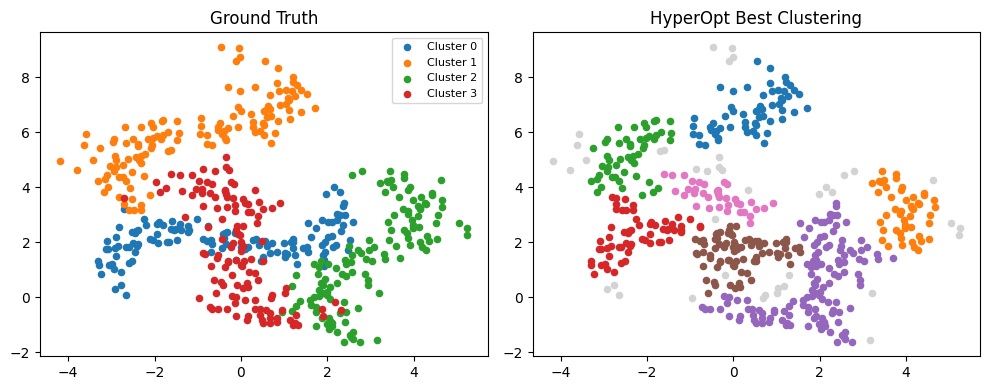

Final ARI: 0.30508924767267187


In [43]:
# Your code here
# Refit best model and visualize
best_model = HDBSCAN(
    min_cluster_size=int(best_params["min_cluster_size"]),
    min_samples=int(best_params["min_samples"]),
    cluster_selection_epsilon=float(best_params["cluster_selection_epsilon"]),
    metric="euclidean"
).fit(X)

best_labels = best_model.labels_

comparison_plot(X, best_labels, y, "HyperOpt Best Clustering")

print("Final ARI:", ari_with_singleton_noise(y, best_labels))

## Exercise 2

<!-- @q -->

The lecture notebook illustrates how you can use an optimizer to cluster texts according to criteria like coverage and coherence.  In the text we used 'fake' data.  Here, we'll use a small set of real data from sklearn's "newsgroups" data set.  The newgroups data is text data that has been harvested from usenet newgroups on several religious topics.  To make this manageable, we'll subsample this data.  Your goal here is to explore the data to get a sense of what sorts of things the different newgroups talk about.  There is no *right* answer here, but as you play with the problem, you will probably find that some results are subjectively better than others.  You might try visualizing things, but chances are good that this will be very hard to interpret.

Try a few parameter settings, and then answer the questions below.

First, gather the data.

In [2]:
#@SHOW
from sklearn.datasets import fetch_20newsgroups
import numpy as np

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")
print("Target distribution")
unique, counts = np.unique(newsgroups_train.target, return_counts=True)
print(np.asarray((unique, counts)).T)

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

You'll note the data is a little messy, so here's a little code to clean it up.  You'll need to install nltk with pip to use the follwoing code.

In [3]:
#@SHOW
#Uncomment the following to install nltk
#%pip install nltk

In [4]:
#@SHOW
#You'll also need to install the punkt tokenizer for nltk
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#@SHOW
import re
import pandas as pd

def clean_post(text):
    """Basic cleaning for a single newsgroup post."""
    # 1. Strip metadata header (everything before first blank line)
    if "\n\n" in text:
        text = text.split("\n\n", 1)[1]
    
    # 2. Remove quoted lines (starting with >)
    text = "\n".join([line for line in text.splitlines() if not line.strip().startswith(">")])
    
    # 3. Remove signatures (common marker is '-- ' or '__')
    text = re.split(r'(--\s|__+)', text)[0]
    
    # 4. Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # Removing signatures
    text = re.split(r'(--\s|__+)', text)[0]
    text = re.sub(r"[^a-zA-Z\s]", " ", text).lower()
    text = re.sub(r"http\S+|www\S+|\S+@\S+|\d+", "", text)

    return text

# Apply cleaning
cleaned_docs = [clean_post(doc) for doc in newsgroups_train.data]

# Sentence tokenize
all_sentences = []
for idx, doc in enumerate(cleaned_docs):
    sentences = nltk.sent_tokenize(doc)
    for sent in sentences:
        all_sentences.append({"sentence": sent, "label": categories[newsgroups_train.target[idx]], "doc_id": idx})

# Build dataframe
df_sentences = pd.DataFrame(all_sentences)
df_sentences = df_sentences[df_sentences["sentence"].str.len() > 25]

print(df_sentences.head(10))
print("Shape:", df_sentences.shape)

                                            sentence                   label  \
0  mike boulder snsc unr edu  mike mccormick  wri...             alt.atheism   
1  in a previous article  cdcolvin rahul net  chr...  soc.religion.christian   
2  robert weiss  psyrobtw ubvmsb cc buffalo edu  ...  soc.religion.christian   
3  in article      apr              mac cc macals...      talk.religion.misc   
4  in article  apr                        athos r...             alt.atheism   
5  there were some recent developments in the dis...  soc.religion.christian   
6  the divine masters most christians would agree...  soc.religion.christian   
7  in article   apr             skyblu ccit arizo...      talk.religion.misc   
8  in article                 f  rusnews w   w ma...      talk.religion.misc   
9  in a previous article  cdcolvin rahul net  chr...  soc.religion.christian   

   doc_id  
0       0  
1       1  
2       2  
3       3  
4       4  
5       5  
6       6  
7       7  
8       8  

From here, you can just adapt the code that is in the lecture notebooks.  If you run into memory errors, sample your newsgroup data down to 1000 sentences per newsgroup.  This should still give you a pretty good sample.

In [8]:
# Your code here
df_sampled = (
    df_sentences
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 1000), random_state=42))
    .reset_index(drop=True)
)
print(df_sampled["label"].value_counts())

label
alt.atheism               598
talk.religion.misc        480
soc.religion.christian    375
Name: count, dtype: int64


/tmp/ipykernel_19233/4124367377.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 1000), random_state=42))


In [9]:
# Your code here
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    df_sampled["sentence"].tolist(),
    show_progress_bar=True,
    normalize_embeddings=True
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 46/46 [01:41<00:00,  2.20s/it]


In [10]:
# Your code here
import umap
'''
umap_configs = [
    {"n_neighbors": 5, "min_dist": 0.05},
    {"n_neighbors": 10, "min_dist": 0.1},
    {"n_neighbors": 25, "min_dist": 0.25},
]
'''

umap_configs = [
    {"n_neighbors": 10, "min_dist": 0.05},
    {"n_neighbors": 25, "min_dist": 0.1},
    {"n_neighbors": 50, "min_dist": 0.25},
]

umap_projections = []
for cfg in umap_configs:
    reducer = umap.UMAP(
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        n_components=2,
        metric="cosine",
        random_state=42
    )
    umap_projections.append(reducer.fit_transform(embeddings))

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
# Your code here
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan
from hyperopt import STATUS_OK

def coverage_score(labels):
    labels = np.asarray(labels)
    return (labels != -1).mean()

def cluster_coherence_from_embeddings(embeds, labels):
    """
    Return (global_coherence, per_cluster_dict).
    global_coherence is the size-weighted mean of per-cluster mean cosine similarity.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() < 2 or len(np.unique(labels[mask])) < 1:
        return -1.0, {}

    per_cluster = {}
    totals = 0
    weighted_sum = 0.0

    for c in np.unique(labels[mask]):
        idx = np.where(labels == c)[0]
        if len(idx) < 2:
            per_cluster[int(c)] = -1.0
            continue
        sims = cosine_similarity(embeds[idx], embeds[idx])
        # take strict upper triangle to avoid self-similarity
        ut = np.triu_indices_from(sims, k=1)
        vals = sims[ut]
        if len(vals) == 0:
            per_cluster[int(c)] = -1.0
            continue
        coh = float(np.mean(vals))
        per_cluster[int(c)] = coh
        weighted_sum += coh * len(idx)
        totals += len(idx)

    if totals == 0:
        return -1.0, per_cluster

    global_coh = weighted_sum / totals
    # Rescale to [0,1] for visual comparability (optional, cosine sim already ~[0,1])
    return float(global_coh), per_cluster

def make_objective(umap_projections, embeddings, coverage_weight=0.5, min_coverage=0.5):
    # Note: coherence is computed from the original embeddings (semantic space),
    # while clustering happens in 2D (chosen UMAP projection).
    def objective(params):
        umap_ix = int(params["umap_ix"])
        min_cluster_size = int(params["min_cluster_size"])
        min_samples = int(params["min_samples"])

        coords_2d = umap_projections[umap_ix]

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=0.0,
            metric="euclidean"  # on UMAP space
        )
        labels = clusterer.fit_predict(coords_2d)

        cov = coverage_score(labels)
        coh, _ = cluster_coherence_from_embeddings(embeddings, labels)

        if coh < 0:
            score = -1.0
        else:
            score = coverage_weight * cov + (1 - coverage_weight) * coh

        # Soft penalty for not meeting coverage target
        if cov < min_coverage:
            score -= (min_coverage - cov) * 2.0

        return {"loss": -score, "status": STATUS_OK, "labels": labels, "umap_ix": umap_ix}
    return objective

objective = make_objective(
    umap_projections, 
    embeddings, 
    #coverage_weight=0.3, 
    #min_coverage=0.2
    coverage_weight=0.6, 
    min_coverage=0.4
)

from hyperopt import fmin, tpe, hp, Trials

space = {
    "umap_ix": hp.choice("umap_ix", [0, 1, 2]),
    "min_cluster_size": hp.quniform("min_cluster_size", 5, 50, 1),
    "min_samples": hp.quniform("min_samples", 1, 10, 1),
}

trials = Trials()
fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=60, trials=trials)

# --- Extract the best trial ---
best_trial = min(trials.trials, key=lambda t: t["result"]["loss"])
best_umap_ix = int(best_trial["result"]["umap_ix"])

# Extract best parameters
best_params = {
    "min_cluster_size": int(best_trial["misc"]["vals"]["min_cluster_size"][0]),
    "min_samples": int(best_trial["misc"]["vals"]["min_samples"][0])
}

print("Best UMAP projection index:", best_umap_ix)
print("Best parameters:", best_params)

# --- Refit the best HDBSCAN model on the correct projection ---
best_model = hdbscan.HDBSCAN(
    min_cluster_size=best_params["min_cluster_size"],
    min_samples=best_params["min_samples"],
    metric="euclidean"
).fit(umap_projections[best_umap_ix])

# These are now the correct labels for your text data
best_labels = best_model.labels_

print("✅ best_labels length:", len(best_labels))

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  3%|▎         | 2/60 [00:00<00:16,  3.58trial/s, best loss: -0.6666761108209409]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  5%|▌         | 3/60 [00:00<00:14,  3.93trial/s, best loss: -0.6666761108209409]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



  7%|▋         | 4/60 [00:01<00:13,  4.05trial/s, best loss: -0.6666761108209409]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 10%|█         | 6/60 [00:01<00:14,  3.60trial/s, best loss: -0.6667859760302145]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 12%|█▏        | 7/60 [00:01<00:13,  3.90trial/s, best loss: -0.6667859760302145]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 13%|█▎        | 8/60 [00:02<00:13,  3.84trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 17%|█▋        | 10/60 [00:02<00:12,  4.04trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 18%|█▊        | 11/60 [00:02<00:11,  4.23trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 20%|██        | 12/60 [00:03<00:11,  4.35trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 22%|██▏       | 13/60 [00:03<00:11,  4.21trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 25%|██▌       | 15/60 [00:03<00:09,  4.68trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 28%|██▊       | 17/60 [00:03<00:07,  5.74trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 32%|███▏      | 19/60 [00:04<00:07,  5.39trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 33%|███▎      | 20/60 [00:04<00:07,  5.15trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 37%|███▋      | 22/60 [00:05<00:08,  4.61trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 38%|███▊      | 23/60 [00:05<00:07,  4.96trial/s, best loss: -0.6673720915781861]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 42%|████▏     | 25/60 [00:05<00:07,  4.49trial/s, best loss: -0.6689567858014619]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 43%|████▎     | 26/60 [00:05<00:06,  5.02trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 47%|████▋     | 28/60 [00:06<00:05,  5.43trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 50%|█████     | 30/60 [00:06<00:05,  5.01trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 53%|█████▎    | 32/60 [00:07<00:06,  4.37trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 57%|█████▋    | 34/60 [00:07<00:05,  5.11trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 58%|█████▊    | 35/60 [00:07<00:04,  5.20trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 62%|██████▏   | 37/60 [00:08<00:05,  4.31trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 65%|██████▌   | 39/60 [00:08<00:04,  4.54trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 68%|██████▊   | 41/60 [00:09<00:03,  5.43trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 72%|███████▏  | 43/60 [00:09<00:03,  5.07trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 73%|███████▎  | 44/60 [00:09<00:03,  4.94trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 77%|███████▋  | 46/60 [00:09<00:02,  5.53trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 80%|████████  | 48/60 [00:10<00:02,  5.40trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 83%|████████▎ | 50/60 [00:10<00:01,  6.38trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 87%|████████▋ | 52/60 [00:10<00:01,  6.54trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 90%|█████████ | 54/60 [00:11<00:01,  5.55trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 92%|█████████▏| 55/60 [00:11<00:00,  5.50trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 95%|█████████▌| 57/60 [00:11<00:00,  5.72trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 98%|█████████▊| 59/60 [00:12<00:00,  5.63trial/s, best loss: -0.6693245986577813]

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



100%|██████████| 60/60 [00:12<00:00,  4.81trial/s, best loss: -0.6693245986577813]
Best UMAP projection index: 2
Best parameters: {'min_cluster_size': 16, 'min_samples': 1}
✅ best_labels length: 1453


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Set up a helper function to inspect clusters


Create a function that enables you to print out a sample of sentences from a specified cluster.  The function should also print the size and coherence of the cluster.

In [13]:
import random
import numpy as np

def inspect_cluster(cluster_id, sentences, labels, per_cluster, n_samples=5, seed=42):
    """
    Inspect one cluster: randomly sample N sentences from it.
    
    Parameters
    ----------
    cluster_id : int
        The cluster to inspect.
    sentences : list of str
        Original sentences (aligned with labels).
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    per_cluster : dict
        Dictionary of coherence scores {cluster_id: score}.
    n_samples : int
        Number of sentences to show.
    seed : int
        Random seed for reproducibility.
    """

# TODO: Replace with your code (fill)
    # Convert labels to numpy array for indexing
    labels = np.asarray(labels)
    
    # Find indices of sentences belonging to the cluster
    idx = np.where(labels == cluster_id)[0]
    
    # Handle empty or noise clusters
    if len(idx) == 0:
        print(f"⚠️ Cluster {cluster_id} not found or empty.")
        return
    
    # Get cluster coherence (if available)
    coherence = per_cluster.get(cluster_id, None)
    coh_text = f"{coherence:.3f}" if coherence is not None else "N/A"
    
    # Print summary info
    print(f"\n=== Cluster {cluster_id} ===")
    print(f"Size: {len(idx)} sentences")
    print(f"Coherence: {coh_text}")
    print("-" * 60)
    
    # Randomly sample sentences
    random.seed(seed)
    sample_idx = random.sample(list(idx), k=min(n_samples, len(idx)))
    
    for i in sample_idx:
        print(f"- {sentences[i]}")

### Inspect multiple clusters


Build a function that uses `inspect_cluster` to print out a sample of sentences for the top N clusters sorted by either size or coherence.

In [14]:

best_coh, per_cluster = cluster_coherence_from_embeddings(embeddings, best_labels)

def sample_clusters(sentences, labels, per_cluster, 
                    rank_by="size", top_m=5, n_samples=3, seed=42):
    """
    Inspect multiple clusters ranked by size or coherence.
    Delegates to inspect_cluster for display.
    
    Parameters
    ----------
    sentences : list of str
        Original sentences (aligned with labels).
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    per_cluster : dict
        Dictionary of coherence scores {cluster_id: score}.
    rank_by : str, "size" or "coherence"
        How to rank clusters.
    top_m : int
        Number of clusters to inspect.
    n_samples : int
        Number of sentences per cluster.
    seed : int
        Random seed.
    """

    # TODO: Replace with your code (fill)
    labels = np.asarray(labels)
    
    # Exclude noise (-1)
    unique_clusters = [c for c in np.unique(labels) if c != -1]
    
    # Compute cluster sizes
    cluster_sizes = {c: np.sum(labels == c) for c in unique_clusters}
    
    # Build ranking list
    if rank_by == "size":
        ranked = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
    elif rank_by == "coherence":
        ranked = sorted(per_cluster.items(), key=lambda x: x[1], reverse=True)
    else:
        raise ValueError("rank_by must be 'size' or 'coherence'")
    # Keep only top M clusters
    top_clusters = [c for c, _ in ranked[:top_m]]
    
    # ✅ NEW: Inspect each top cluster
    print(f"\nInspecting top {len(top_clusters)} clusters by {rank_by}:\n")
    for c in top_clusters:
        inspect_cluster(c, sentences, labels, per_cluster,
                        n_samples=n_samples, seed=seed)
# Inspect top 5 clusters by coherence
sample_clusters(df_sentences["sentence"].tolist(), best_labels, per_cluster, 
                rank_by="size", top_m=5, n_samples=10)


Inspecting top 3 clusters by size:


=== Cluster 2 ===
Size: 1397 sentences
Coherence: 0.164
------------------------------------------------------------
-  darren     dr nancy s sweetie  kilroy gboro rowan edu  writes  darren  in an earlier article  i explained that what many people find darren  arrogant about christians is that some christians profess darren  absolute certainty about their beliefs and doctrines  and darren  in short  the problem is that no matter how good your sources darren  are  if any part of your doctrines or beliefs rest on your own darren  thinking and reasoning  then those doctrines are suspect  the point that darren raises is a very lutheran viewpoint  while reason is a gift from god  it is also infected by sin  yet we do not reject reason entirely  and neither  i think  does darren  we need reason  as darren himself has pointed out  to comprehend god s revelation of himself in the bible  but reason alone is not sufficient to comprehend and believe the word 

### Compare newsgroups


Build a visualization function that produces bar charts indicating the prevalence (as proportion) of the top N clusters by size (overall) in the three newgroups.  This should allow you to see the different intensities of each topic in the different newsgroups.  After you've done so, use the `inspect_cluster` method above to look at clusters that seem to be very different (or the same!) between newsgroups.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_cluster_profiles(top_n, labels, targets):
    """
    Visualize prevalence of top N clusters across newsgroups.
    
    Parameters
    ----------
    top_n : int
        Number of largest clusters to display.
    labels : array-like
        Cluster labels for each sentence (-1 = noise).
    targets : array-like of str
        Ground truth newsgroup name for each sentence (aligned with labels).
    """
    # TODO: Replace with your code (fill)
    labels = np.asarray(labels)
    targets = np.asarray(targets)

    # Exclude noise (-1)
    valid_mask = labels != -1
    labels = labels[valid_mask]
    targets = targets[valid_mask]

    # Compute cluster sizes
    cluster_sizes = pd.Series(labels).value_counts().sort_values(ascending=False)

    # Get top N clusters
    top_clusters = cluster_sizes.head(top_n).index.tolist()

    # Build a dataframe of counts: rows = cluster, cols = newsgroup labels
    df = pd.DataFrame({"cluster": labels, "newsgroup": targets})
    cluster_group_counts = (
        df[df["cluster"].isin(top_clusters)]
        .groupby(["cluster", "newsgroup"])
        .size()
        .unstack(fill_value=0)
    )

    # Convert counts to proportions per cluster
    cluster_props = cluster_group_counts.div(cluster_group_counts.sum(axis=1), axis=0)

    # --- Plot ---
    ax = cluster_props.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        colormap="tab10",
        edgecolor="black"
    )

    plt.title(f"Distribution of Top {top_n} Clusters Across Newsgroups", fontsize=14)
    plt.xlabel("Cluster ID")
    plt.ylabel("Proportion of Sentences")
    plt.legend(title="Newsgroup", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

1453
1453
df_sampled: 1453
embeddings: 1453
umap projections: [(1453, 2), (1453, 2), (1453, 2)]
best_labels: 1453


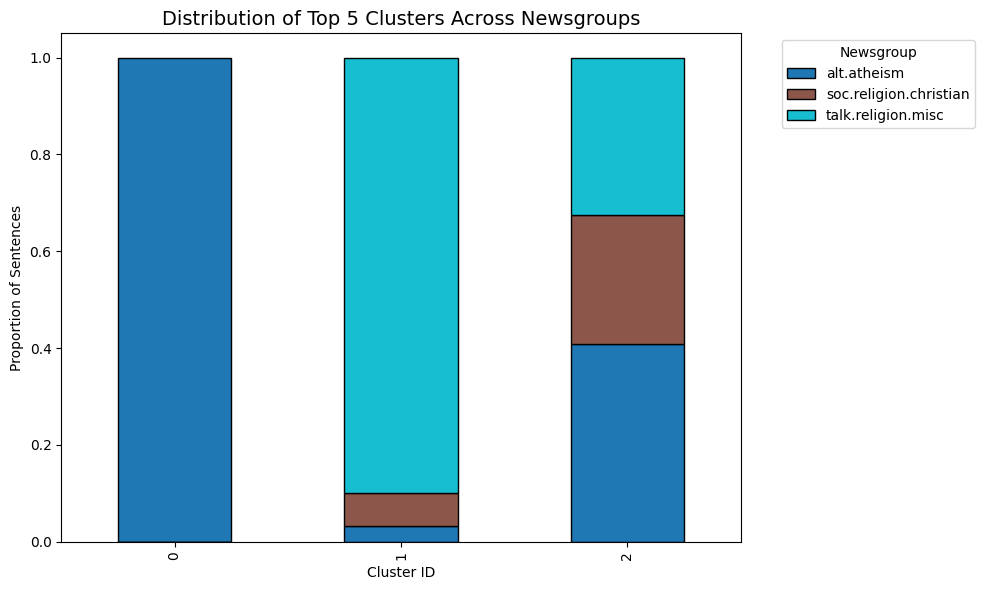

In [16]:
print(len(df_sentences))
print(len(best_labels))
print("df_sampled:", len(df_sampled))
print("embeddings:", len(embeddings))
print("umap projections:", [p.shape for p in umap_projections])  # if you made several
print("best_labels:", len(best_labels))
df_sampled["cluster"] = best_labels
visualize_cluster_profiles(
    top_n=5,
    labels=df_sampled["cluster"].values,
    targets=df_sampled["label"].values
)


### Explore and reflect


Go back now and play with the preceding code to see if you can generate clusterings that make sense, and reveal true differences.  Chances are, you've got some clusters that are filled with useless bits of text that came from the tokenizer.  Can you modify the tokenizer to improve this at all? You can also fiddle with how you've parameterized your loss function, or even modify it. For instance, you might have lots of tiny clusters, but perhaps you want larger, more robust clusters?

Once you're satisfied, try to build an understanding of the differences between the newsgroups.  Do the clusters you've found make sense, given your understanding of the topics being discussed here?  You might need to google a little to figure out what some of these topics are about!

Once you're done, answer the following:

1. What modifications did you try and why?  What seemed to work?  What didn't?
2. How do you decide if a cluster is "good" or not.  Do you think coherence does a good job?  Can you think of anything that better captures your intuitions?
3. What are the clearest differences you can find between the three newsgroups? Tell me if this makes sense given your understanding of the topic areas.

*Enter your answer in this cell*
1. Added two more items to the clean_post function (Removing URLs, email addresses, and numbers). Removing sentences under 25 characters seemed to be the best improvement. Had removed signatures but didn't seem to make an impact.
2. Good clusters have high coherence scores and visually have a relatively uniform bar chart. I think coherence has a good correlation with a positive result but not necessarily definitive. A good cluster also has a good size that's representative and not overtly general.
3. Having a basis in religion seems to be the most common differentiator with cluster 0 being relatively atheist and cluster 1 having a more religious focus. Cluster 2 is too large and heterogeneous and covers broader topics as opposed to the first two. This seems accurate given conservative versus more progressive political stances.